# Import & unzip images, imports

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip /content/drive/MyDrive/OTU_2d.zip -d /content

In [26]:
import os

data_dir = '/content/OTU_2d'

print(os.listdir(data_dir))

['train_cls.txt', 'val_cls.txt', 'train.txt', 'val.txt', 'annotations', 'images']


In [ ]:
!pip install albumentations segmentation-models-pytorch

# Load images

In [27]:
import torch
from torch.utils.data import Dataset
import cv2
import albumentations as A
import numpy as np

class OvarianSegDataset(Dataset):
    """
    Class to load ultrasound images and their corresponding segmentation masks

    Attributes:
      images_directory: directory containing images
      annotations_directory: directory containing annotations (segmentation masks)
      list_file: txt file with images IDs (train.txt and val.txt)
      transform: optional argument for augmentations
    """

    def __init__(self, images_directory, annotations_directory, list_file, transform=None):
        self.images_directory = images_directory
        self.annotations_directory = annotations_directory
        self.transform = transform

        with open(list_file, 'r') as f:
            self.image_ids = [line.strip() for line in f if line.strip()]

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]

        # file paths
        img_path = os.path.join(self.images_directory, f"{image_id}.JPG")
        mask_path = os.path.join(self.annotations_directory, f"{image_id}_binary.PNG")

        # read image in RGB (OpenCV default)
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)
        # read mask in grayscale (0 or 255)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if self.transform is not None:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        # convert to PyTorch tensors
        # image shape: [C, H, W], mask shape: [H, W]
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
        mask = torch.tensor(mask, dtype=torch.long)

        return image, mask

In [31]:
"""
Test to see how masks in annotations folder look like
Result should be [0 1]: background is 0, foreground (tumor) is 1
"""

import cv2
import numpy as np

mask_path = '/content/OTU_2d/annotations/1_binary.PNG'

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
print(np.unique(mask))

[0 1]


# Data Augmentation

In [8]:
import albumentations as A

train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
], additional_targets={'mask': 'mask'})

val_transform = A.Compose([
    A.Resize(256, 256),
], additional_targets={'mask': 'mask'})


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:58: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


# Load data

In [9]:
from torch.utils.data import DataLoader

images_directory = os.path.join(data_dir, 'images')
annotations_directory = os.path.join(data_dir, 'annotations')
train_list = os.path.join(data_dir, 'train.txt')
val_list = os.path.join(data_dir, 'val.txt')

train_dataset = OvarianSegDataset(
    images_directory=images_directory,
    annotations_directory=annotations_directory,
    list_file=train_list,
    transform=train_transform
)

val_dataset = OvarianSegDataset(
    images_directory=images_directory,
    annotations_directory=annotations_directory,
    list_file=val_list,
    transform=val_transform
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)


In [10]:
sample_img, sample_mask = train_dataset[0]
print("Image shape:", sample_img.shape)  # (3 - channels RGB color images, Height, Width)
print("Mask shape:", sample_mask.shape)  # (1 - channel grey images, Height, Width)

Image shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])


# U-net model

In [11]:
import segmentation_models_pytorch as smp
import torch.nn as nn
import torch.optim as optim

"""
U-Net with pretrained encoder
"""
model = smp.Unet(
    encoder_name="resnet34",
    in_channels=3,           # 3 color channels RGB
    classes=1,               # 1 output channel (binary)
    activation=None
)


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 241MB/s]


In [12]:
dice_loss = smp.losses.DiceLoss(mode='binary')
bce_loss = nn.BCEWithLogitsLoss()

def combined_loss(pred, mask):
    # pred: [B, 1, H, W], mask: [B, H, W]
    mask = mask.float().unsqueeze(1)  # make mask [B, 1, H, W]
    return 0.5 * dice_loss(pred, mask) + 0.5 * bce_loss(pred, mask)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = combined_loss(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = combined_loss(outputs, masks)
            val_loss += loss.item()

    # print average losses
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")


Epoch [1/20] - Train Loss: 0.4779 | Val Loss: 0.3581
Epoch [2/20] - Train Loss: 0.2948 | Val Loss: 0.2383
Epoch [3/20] - Train Loss: 0.2197 | Val Loss: 0.2021
Epoch [4/20] - Train Loss: 0.1800 | Val Loss: 0.1789
Epoch [5/20] - Train Loss: 0.1516 | Val Loss: 0.1557
Epoch [6/20] - Train Loss: 0.1364 | Val Loss: 0.1434
Epoch [7/20] - Train Loss: 0.1230 | Val Loss: 0.1359
Epoch [8/20] - Train Loss: 0.1210 | Val Loss: 0.1306
Epoch [9/20] - Train Loss: 0.1132 | Val Loss: 0.1307
Epoch [10/20] - Train Loss: 0.1079 | Val Loss: 0.1252
Epoch [11/20] - Train Loss: 0.1002 | Val Loss: 0.1271
Epoch [12/20] - Train Loss: 0.0890 | Val Loss: 0.1155
Epoch [13/20] - Train Loss: 0.0846 | Val Loss: 0.1182
Epoch [14/20] - Train Loss: 0.0906 | Val Loss: 0.1175
Epoch [15/20] - Train Loss: 0.0822 | Val Loss: 0.1182
Epoch [16/20] - Train Loss: 0.0821 | Val Loss: 0.1148
Epoch [17/20] - Train Loss: 0.0779 | Val Loss: 0.1103
Epoch [18/20] - Train Loss: 0.0768 | Val Loss: 0.1199
Epoch [19/20] - Train Loss: 0.0715 | 

In [16]:
import matplotlib.pyplot as plt

model.eval()

val_images, val_masks = next(iter(val_loader))

# move data to GPU if available
val_images = val_images.to(device)
val_masks = val_masks.to(device)

with torch.no_grad():
    outputs = model(val_images)

# outputs: shape [batch_size, 1, H, W]
preds = torch.sigmoid(outputs)
preds = (preds > 0.5).float()

val_images = val_images.cpu()
val_masks = val_masks.cpu()
preds = preds.cpu()


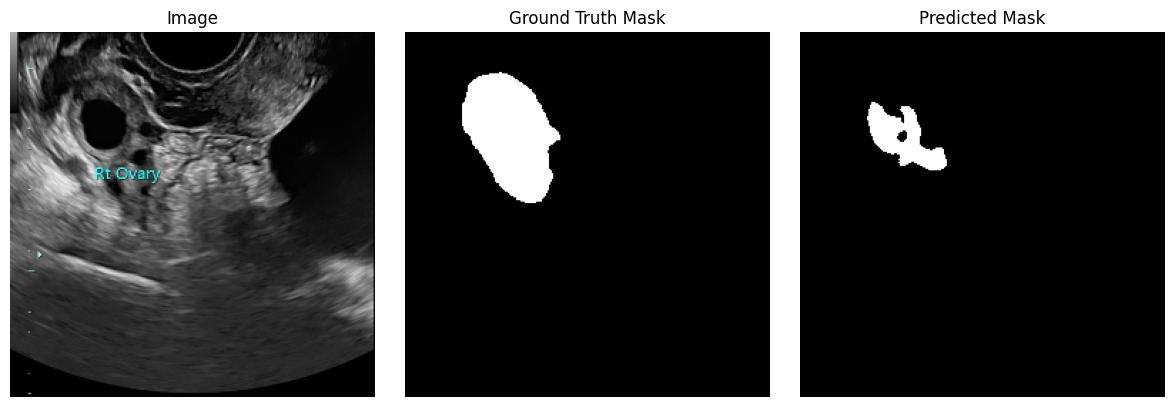

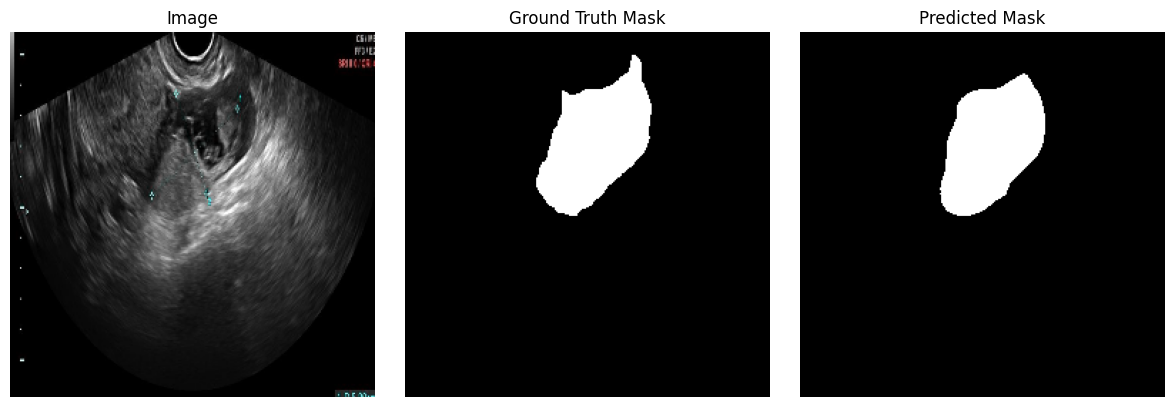

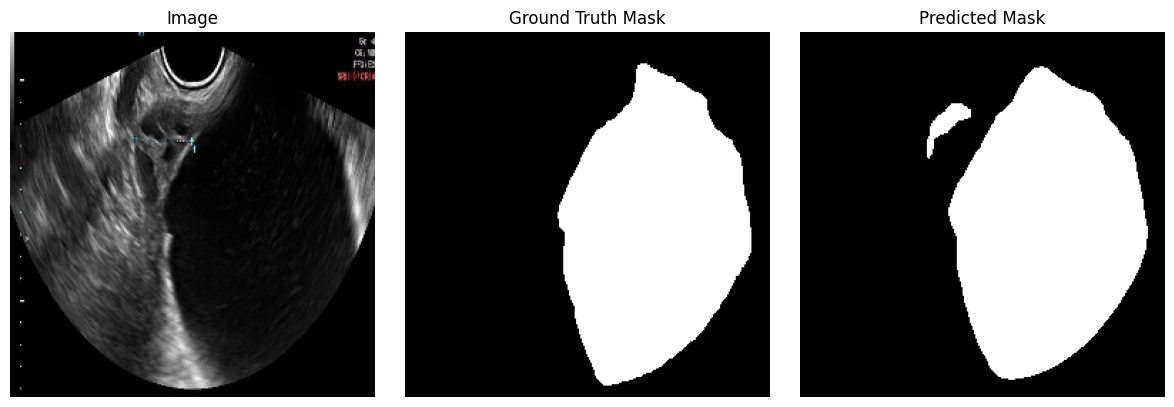

In [17]:
for i in range(3):  # show first 3 images
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))

    # Original image
    # shape: [3, H, W] -> [H, W, 3] for plotting
    img = val_images[i].permute(1, 2, 0).numpy().astype('uint8')

    # Ground-truth mask
    mask = val_masks[i].numpy()

    # Predicted mask
    pred = preds[i][0].numpy()  # preds[i] has shape [1, H, W], so index [0]

    ax[0].imshow(img)
    ax[0].set_title('Image')
    ax[0].axis('off')

    ax[1].imshow(mask, cmap='gray')
    ax[1].set_title('Ground Truth Mask')
    ax[1].axis('off')

    ax[2].imshow(pred, cmap='gray')
    ax[2].set_title('Predicted Mask')
    ax[2].axis('off')

    plt.tight_layout()
    plt.show()


In [18]:
def dice_coefficient(pred, target, smooth=1e-6):
    # pred, target: binary masks of shape [batch, 1, H, W] or [batch, H, W]
    # ensure float type
    pred = pred.float()
    target = target.float()

    intersection = (pred * target).sum(dim=[1,2,3])
    union = pred.sum(dim=[1,2,3]) + target.sum(dim=[1,2,3])

    dice = (2. * intersection + smooth) / (union + smooth)
    return dice.mean()


In [19]:
model.eval()
all_dice_scores = []

with torch.no_grad():
    for images, masks in val_loader:
        images = images.to(device)
        masks = masks.to(device)
        outputs = model(images)
        # Apply sigmoid + threshold for binary
        preds = torch.sigmoid(outputs)
        preds = (preds > 0.5).float()

        # Compute dice
        batch_dice = dice_coefficient(preds, masks.unsqueeze(1))
        all_dice_scores.append(batch_dice.item())

mean_dice = sum(all_dice_scores) / len(all_dice_scores)
print("Validation Dice Coefficient:", mean_dice)


Validation Dice Coefficient: 0.829391169345985


In [20]:
import os
save_dir = '/content/drive/MyDrive/MMOTU/predictions'
os.makedirs(save_dir, exist_ok=True)

model.eval()
with torch.no_grad():
    for i, (images, masks) in enumerate(val_loader):
        images = images.to(device)
        outputs = model(images)
        preds = torch.sigmoid(outputs)
        preds = (preds > 0.5).float().cpu().numpy()

        # Save each predicted mask in the batch
        for b in range(images.size(0)):
            pred_mask = preds[b, 0, :, :]  # shape [H, W]
            # Convert to 0/255 for saving as an image
            pred_mask = (pred_mask * 255).astype('uint8')
            cv2.imwrite(os.path.join(save_dir, f"val_batch{i}_img{b}_pred.png"), pred_mask)


In [21]:
import torch

def precision_and_recall(pred, target, eps=1e-7):
    """
    pred, target: [B, 1, H, W] or [B, H, W] binary (0/1) tensors
    Returns: precision, recall (averaged over the batch)
    """
    # Ensure same shape and type
    if pred.dim() == 4:
        pred = pred.squeeze(1)  # [B, H, W]
    if target.dim() == 4:
        target = target.squeeze(1)

    pred = pred.float()
    target = target.float()

    # True Positive, False Positive, False Negative
    TP = (pred * target).sum(dim=[1,2])
    FP = (pred * (1 - target)).sum(dim=[1,2])
    FN = ((1 - pred) * target).sum(dim=[1,2])

    precision = (TP + eps) / (TP + FP + eps)
    recall = (TP + eps) / (TP + FN + eps)

    return precision.mean().item(), recall.mean().item()

# Example usage in a validation loop:
model.eval()
all_precisions = []
all_recalls = []

with torch.no_grad():
    for images, masks in val_loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        preds = torch.sigmoid(outputs)
        preds = (preds > 0.5).float()

        batch_precision, batch_recall = precision_and_recall(preds, masks)
        all_precisions.append(batch_precision)
        all_recalls.append(batch_recall)

avg_precision = sum(all_precisions) / len(all_precisions)
avg_recall = sum(all_recalls) / len(all_recalls)

print("Validation Precision:", avg_precision)
print("Validation Recall:", avg_recall)


Validation Precision: 0.8294321450136476
Validation Recall: 0.8847681263745841


In [14]:
torch.save(model.state_dict(), 'ovarian_seg_model.pth')


In [ ]:
model.load_state_dict(torch.load('ovarian_seg_model.pth'))
model.eval()
